In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

data_path = "images/train/"

products = pd.read_csv("products.csv")

# label list
classes = np.unique(products['GS1 Form'])

# Define relevant variables for the ML task
batch_size = 64
num_classes = len(classes)
learning_rate = 0.01
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
"""Loading data with PyTorch"""

# normalizing data ...
transform = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])

# loading data
train_data = torchvision.datasets.ImageFolder(root=data_path, 
                                              transform=transform)

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


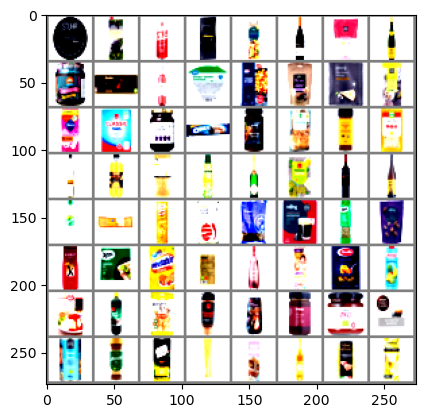

cup-tub gable-top can   bag   gable-top bottle bag   bottle jar   box   bottle sleeve box   bag   box   bag   sleeve box   jar   sleeve jar   bag   jar   tray  bottle bottle bag   bottle bottle tray  bottle bottle bottle sleeve can   can   bag   box   bag   bag   bag   tray  box   bag   bottle sleeve box   gable-top box   bottle bag   cup-tub tray  jar   jar   box   can   jar   box   tube  gable-top bottle tray  box  


In [3]:
"""Functions to show an image"""

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
"""Convolutional Neural Network"""

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

# net = Net(10)

In [5]:
"""This is our Loss function (and optimizer)"""
"""Classification Cross-Entropy loss and SGD with momentum"""

"""Lets use this for now, but later change it to something different"""

import torch.optim as optim

model = Net(num_classes)

# if torch.cuda.is_available():
#     model.cuda()

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

In [6]:
"""Neural network training"""

# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        # images = images.to(device)
        # labels = labels.to(device)
        
        images = images.to()
        labels = labels.to()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/20], Loss: 1.5307
Epoch [2/20], Loss: 1.6212
Epoch [3/20], Loss: 1.3796
Epoch [4/20], Loss: 0.3846
Epoch [5/20], Loss: 0.4196
Epoch [6/20], Loss: 0.4082
Epoch [7/20], Loss: 1.3577
Epoch [8/20], Loss: 0.3577
Epoch [9/20], Loss: 3.8739
Epoch [10/20], Loss: 0.1677
Epoch [11/20], Loss: 1.1625
Epoch [12/20], Loss: 0.2746
Epoch [13/20], Loss: 0.1185
Epoch [14/20], Loss: 0.0814
Epoch [15/20], Loss: 3.6035
Epoch [16/20], Loss: 0.7164
Epoch [17/20], Loss: 2.8698
Epoch [18/20], Loss: 0.3161
Epoch [19/20], Loss: 0.9012
Epoch [20/20], Loss: 1.4588


In [10]:
# saving model
torch.save(model.state_dict(), "model.pth")
print("Saved tested network as model.pth")

Saved PyTorch Model State to model.pth


In [8]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        # images = images.to(device)
        # labels = labels.to(device)
        
        images = images.to()
        labels = labels.to()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(len(products), 100 * correct / total))

Accuracy of the network on the 9986 train images: 71.76046465051071 %


In [11]:
# loading model
model = Net(num_classes)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>